In [23]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
import ta 
from sklearn.model_selection import GridSearchCV
import joblib

In [25]:
# Technical indicators functions
def calculate_ema(df, span, column='close'):
    return df[column].ewm(span=span, adjust=False).mean()

def calculate_rsi(df, period=14, column='close'):
    delta = df[column].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_macd(df, column='close'):
    ema_12 = calculate_ema(df, 12, column)
    ema_26 = calculate_ema(df, 26, column)
    macd = ema_12 - ema_26
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd, signal

def calculate_bollinger_bands(df, column='close', window=20):
    sma = df[column].rolling(window=window).mean()
    std = df[column].rolling(window=window).std()
    return sma + (2 * std), sma - (2 * std)

def calculate_obv(df):
    obv = (np.sign(df['close'].diff()) * df['volume']).fillna(0).cumsum()
    return obv

def calculate_atr(df, period=14):
    high_low = df['high'] - df['low']
    high_close = np.abs(df['high'] - df['close'].shift())
    low_close = np.abs(df['low'] - df['close'].shift())
    tr = pd.Series(np.maximum.reduce([high_low, high_close, low_close]), index=df.index)
    return tr.rolling(window=period).mean()



In [26]:
# Correct the data path
data_path = "D:/tarinning_material/stockdata"  # Updated to your dataset location
csv_files = glob.glob(os.path.join(data_path, "processed_*.csv"))

# Check if files are loaded
if not csv_files:
    print("No processed CSV files found in the directory. Please check the path.")
else:
    print(f"Found {len(csv_files)} processed CSV files.")



Found 12 processed CSV files.


In [28]:
# Load, process, and train models separately
dataframes = {}
for file in csv_files:
    stock_name = os.path.basename(file).replace("processed_", "").replace(".csv", "")  # Extract stock name
    df = pd.read_csv(file, parse_dates=['date'])  # Ensure 'date' column is in datetime format
    df['Stock'] = stock_name  # Assign stock name
    
    # Select features and target
    features = ['open', 'high', 'low', 'volume', 'EMA_20', 'EMA_50', 'RSI_14', 'MACD', 'MACD_Signal', 'Bollinger_High', 'Bollinger_Low', 'OBV', 'ATR']
    target = 'close'
    X = df[features]
    y = df[target]
    # Select features and target
    features = ['open', 'high', 'low', 'volume', 'EMA_20', 'EMA_50', 'RSI_14', 'MACD', 'MACD_Signal', 'Bollinger_High', 'Bollinger_Low', 'OBV', 'ATR']
    target = 'close'
    X = df[features]
    y = df[target]

    # Handle missing values
    X.fillna(X.mean(), inplace=True)  # Fill NaN values with column mean

    # Scale features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    joblib.dump(scaler, os.path.join(data_path, f"scaler_{stock_name}.pkl"))  # Save scaler
    
    # Train-test split (80-20 split)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    # Train Random Forest model with best parameters
    model = RandomForestRegressor(n_estimators=500, max_depth=20, min_samples_split=2, min_samples_leaf=2, random_state=42)
    model.fit(X_train, y_train)
    joblib.dump(model, os.path.join(data_path, f"model_{stock_name}.pkl"))  # Save model
    
    # Evaluate model
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Model trained for {stock_name}: MAE = {mae:.4f}, MSE = {mse:.4f}, R² = {r2:.4f}")
    
    dataframes[stock_name] = df  # Store in dictionary with stock name as key
    print(f"Processed data loaded: {file}")

# Print sample data for verification
for stock, df in dataframes.items():
    print(f"\nSample data for {stock}:")
    print(df.head())

C:\Users\HP\AppData\Local\Temp\ipykernel_2424\868832596.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)  # Fill NaN values with column mean


Model trained for AXISBANK: MAE = 6.2541, MSE = 101.1734, R² = 0.9993
Processed data loaded: D:/tarinning_material/stockdata\processed_AXISBANK.csv


C:\Users\HP\AppData\Local\Temp\ipykernel_2424\868832596.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)  # Fill NaN values with column mean


Model trained for CIPLA: MAE = 2.9073, MSE = 19.2963, R² = 0.9994
Processed data loaded: D:/tarinning_material/stockdata\processed_CIPLA.csv


C:\Users\HP\AppData\Local\Temp\ipykernel_2424\868832596.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)  # Fill NaN values with column mean


Model trained for INFY: MAE = 12.0532, MSE = 357.2900, R² = 0.9996
Processed data loaded: D:/tarinning_material/stockdata\processed_INFY.csv


C:\Users\HP\AppData\Local\Temp\ipykernel_2424\868832596.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)  # Fill NaN values with column mean


Model trained for IOC: MAE = 2.5536, MSE = 18.2549, R² = 0.9991
Processed data loaded: D:/tarinning_material/stockdata\processed_IOC.csv


C:\Users\HP\AppData\Local\Temp\ipykernel_2424\868832596.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)  # Fill NaN values with column mean


Model trained for ITC: MAE = 2.4554, MSE = 45.4761, R² = 0.9995
Processed data loaded: D:/tarinning_material/stockdata\processed_ITC.csv


C:\Users\HP\AppData\Local\Temp\ipykernel_2424\868832596.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)  # Fill NaN values with column mean


Model trained for OIL: MAE = 3.2771, MSE = 28.7222, R² = 0.9998
Processed data loaded: D:/tarinning_material/stockdata\processed_OIL.csv


C:\Users\HP\AppData\Local\Temp\ipykernel_2424\868832596.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)  # Fill NaN values with column mean


Model trained for ONGC: MAE = 4.2619, MSE = 54.2134, R² = 0.9997
Processed data loaded: D:/tarinning_material/stockdata\processed_ONGC.csv


C:\Users\HP\AppData\Local\Temp\ipykernel_2424\868832596.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)  # Fill NaN values with column mean


Model trained for RELIANCE: MAE = 8.9057, MSE = 235.7430, R² = 0.9992
Processed data loaded: D:/tarinning_material/stockdata\processed_RELIANCE.csv


C:\Users\HP\AppData\Local\Temp\ipykernel_2424\868832596.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)  # Fill NaN values with column mean


Model trained for SBIN: MAE = 1.5544, MSE = 5.6901, R² = 0.9998
Processed data loaded: D:/tarinning_material/stockdata\processed_SBIN.csv


C:\Users\HP\AppData\Local\Temp\ipykernel_2424\868832596.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)  # Fill NaN values with column mean


Model trained for SUNPHARMA: MAE = 5.6335, MSE = 75.2440, R² = 0.9994
Processed data loaded: D:/tarinning_material/stockdata\processed_SUNPHARMA.csv


C:\Users\HP\AppData\Local\Temp\ipykernel_2424\868832596.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)  # Fill NaN values with column mean


Model trained for TATACHEM: MAE = 1.3887, MSE = 5.3506, R² = 0.9996
Processed data loaded: D:/tarinning_material/stockdata\processed_TATACHEM.csv


C:\Users\HP\AppData\Local\Temp\ipykernel_2424\868832596.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)  # Fill NaN values with column mean


Model trained for TCS: MAE = 10.3929, MSE = 212.2121, R² = 0.9996
Processed data loaded: D:/tarinning_material/stockdata\processed_TCS.csv

Sample data for AXISBANK:
        date    open    high     low   close    volume     Stock      EMA_20  \
0 2005-01-03  187.00  190.00  185.15  188.95  276055.0  AXISBANK  188.950000   
1 2005-01-04  188.05  191.30  187.00  188.05  195660.0  AXISBANK  188.864286   
2 2005-01-05  189.00  189.25  176.00  183.60  275045.0  AXISBANK  188.362925   
3 2005-01-06  181.00  187.90  177.00  182.50  257265.0  AXISBANK  187.804551   
4 2005-01-07  185.80  190.30  182.25  189.10  387115.0  AXISBANK  187.927927   

       EMA_50  RSI_14      MACD  MACD_Signal  Bollinger_High  Bollinger_Low  \
0  188.950000     NaN  0.000000     0.000000             NaN            NaN   
1  188.914706     NaN -0.071795    -0.014359             NaN            NaN   
2  188.706286     NaN -0.482212    -0.107930             NaN            NaN   
3  188.462902     NaN -0.886018    -0

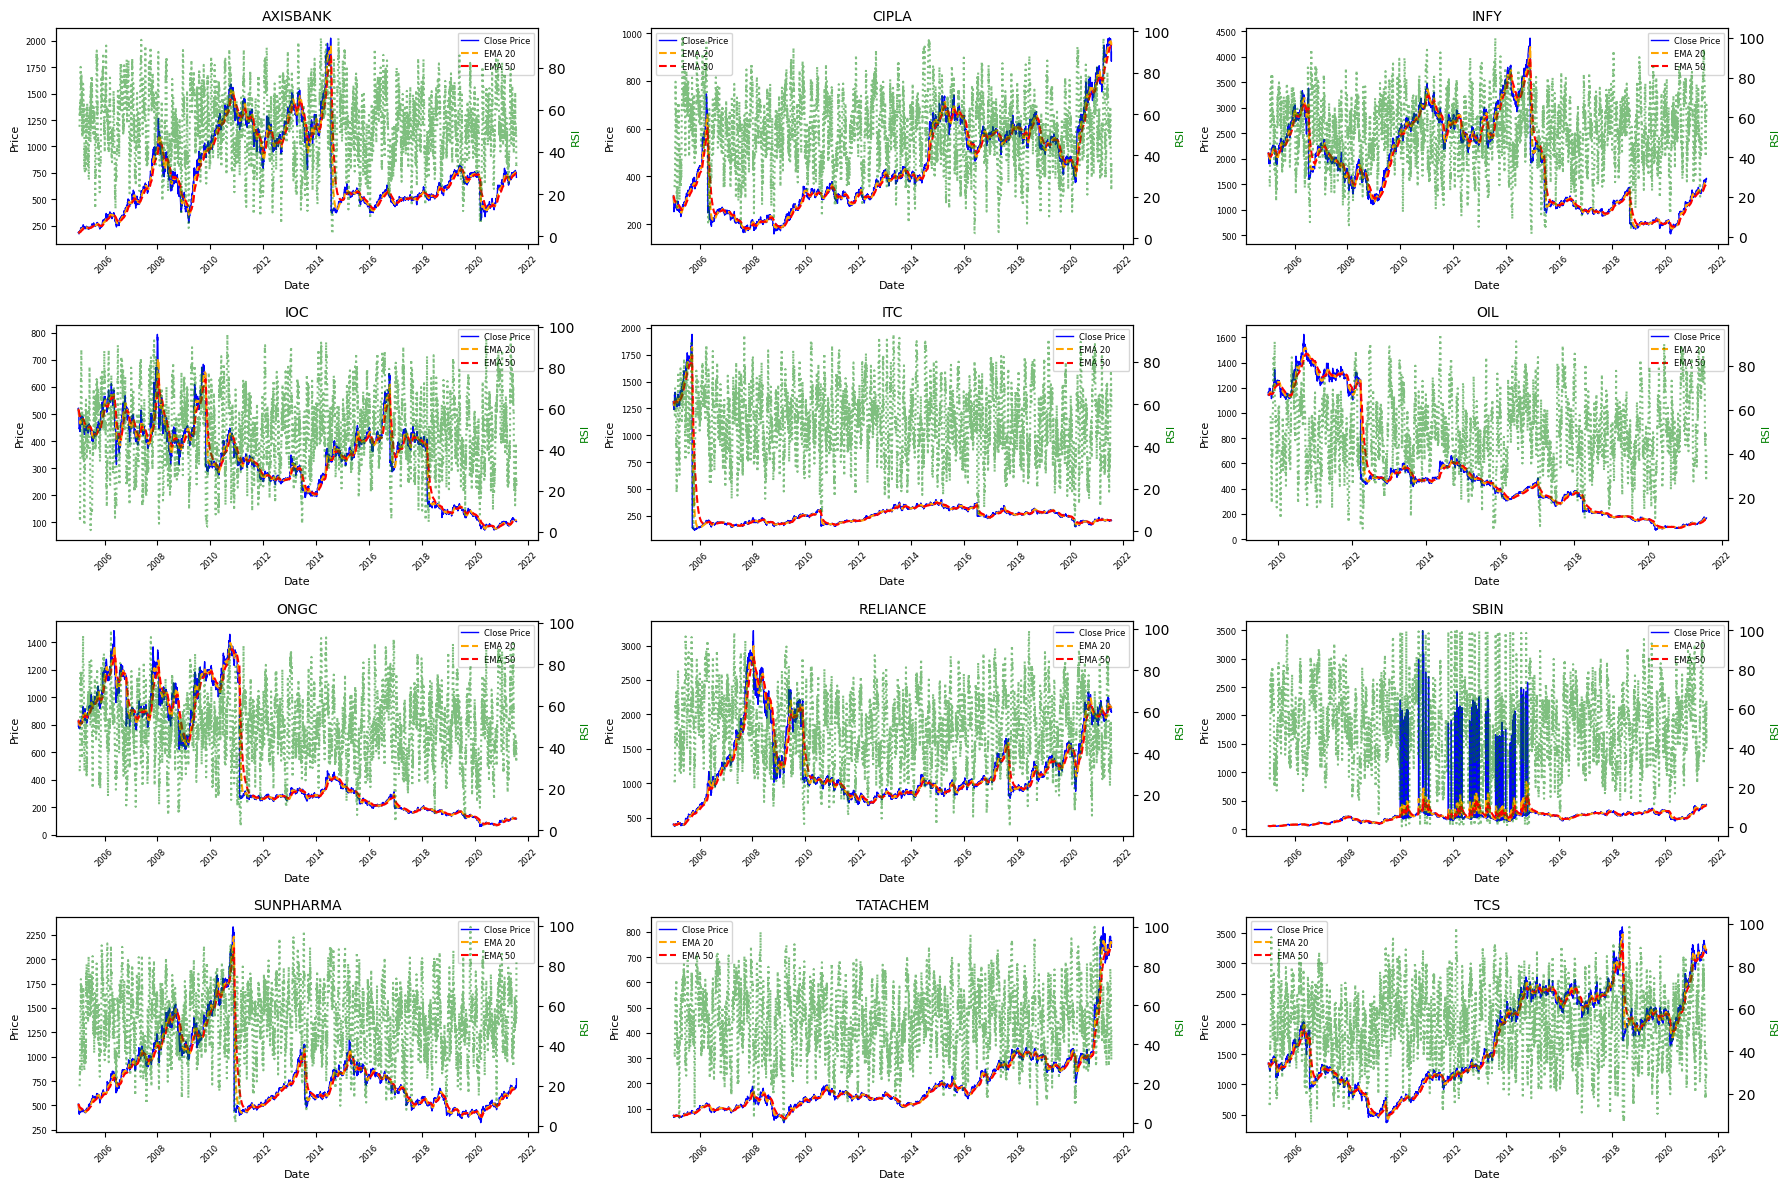

In [29]:
import matplotlib.pyplot as plt

# Set up subplots to fit 12 datasets in a single screen (4 rows x 3 columns)
num_stocks = len(dataframes)
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 12))
axes = axes.flatten()

# Plot each dataset
for i, (stock, df) in enumerate(dataframes.items()):
    if i >= 12:  # Limit to 12 datasets
        break
    
    ax = axes[i]
    ax.plot(df['date'], df['close'], label='Close Price', color='blue', linewidth=1)
    ax.plot(df['date'], df['EMA_20'], label='EMA 20', color='orange', linestyle='dashed')
    ax.plot(df['date'], df['EMA_50'], label='EMA 50', color='red', linestyle='dashed')
    
    # Optional: Highlight RSI if available
    if 'RSI_14' in df.columns:
        ax2 = ax.twinx()
        ax2.plot(df['date'], df['RSI_14'], label='RSI 14', color='green', linestyle='dotted', alpha=0.5)
        ax2.set_ylabel("RSI", color='green', fontsize=8)
    
    ax.set_title(stock, fontsize=10)
    ax.set_xlabel("Date", fontsize=8)
    ax.set_ylabel("Price", fontsize=8)
    ax.legend(fontsize=6)
    ax.tick_params(axis='x', rotation=45, labelsize=6)
    ax.tick_params(axis='y', labelsize=6)

# Adjust layout
plt.tight_layout()
plt.show()


In [41]:
# User input for prediction
stock_name = input("Enter stock name: ")
if stock_name not in dataframes:
    print("Stock not found in dataset.")
else:
    model_path = os.path.join(data_path, f"model_{stock_name}.pkl")
    scaler_path = os.path.join(data_path, f"scaler_{stock_name}.pkl")
    if os.path.exists(model_path) and os.path.exists(scaler_path):
        model = joblib.load(model_path)
        scaler = joblib.load(scaler_path)
        
        # Collect user input for features in a single line
        feature_names = ['open', 'high', 'low', 'volume', 'EMA_20', 'EMA_50', 'RSI_14', 'MACD', 'MACD_Signal', 'Bollinger_High', 'Bollinger_Low', 'OBV', 'ATR']
        user_input = input(f"Enter feature values in order ({', '.join(feature_names)}), separated by commas: ")
        input_features = list(map(float, user_input.split(',')))
        
        # Scale input features
        input_scaled = scaler.transform([input_features])
        
        # Predict closing price
        predicted_close = model.predict(input_scaled)
        print(f"Predicted Closing Price for {stock_name}: {predicted_close[0]:.2f}")
    else:
        print("Model or scaler not found for the selected stock.")

Predicted Closing Price for AXISBANK: 434.83


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
